In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from GMHMM import GMHMM
%load_ext autoreload
%autoreload 2

In [2]:
np.warnings.filterwarnings('error')

In [3]:
data = pd.read_csv('EMGaussian.data', sep=' ').values

In [4]:
import numpy as np

class KMeans:
    def __init__(self, k=2, tol=1e-3):
        self.k = k
        self.tol = tol

    def fit(self, X):
        # Centers are initialized at random (centered) locations
        # within X's standard deviation
        self.k_centers = 2*X.std()*(np.random.random(size=(X.shape[1], self.k))-0.5)

        niter = 0
        distortion_new = 0

        while niter < 2 or np.linalg.norm(distortion - distortion_new) > self.tol:
            distortion = distortion_new
            dists = np.sum((X[:, :, np.newaxis] - self.k_centers)**2, axis=1)
            cluster_assignement = np.argmin(dists, axis=1)

            for cluster_n in range(self.k):
                self.k_centers[:, cluster_n] = np.mean(X[cluster_assignement==cluster_n, :], axis=0)

            distortion_new = np.sum(np.min(dists, axis=1))
            niter += 1

        # Store the last distortion
        self.distortion = distortion_new

    def predict(self, X):
        dists = np.sum((X[:, :, np.newaxis] - self.k_centers)**2, axis=1)
        cluster_assignement = np.argmin(dists, axis=1)

        return cluster_assignement

In [5]:
def mat_product(a, sigma):
    """ Auxiliary function for computing the product (a^T sigma a)
    """
    return np.sum(a.reshape(a.shape[0], 1, -1).dot(sigma)[:, 0, :]*a, axis=1)

def gaussian_density(mu, sigma):
    """ Auxiliary function for defining the gaussian density function for mean mu
    and covariance matrix sigma.
    
    Args:
        - mu: array of shape (d,)
        - sigma: ndarray of shape (d, d)
        
    Returns:
        function that take as an argument a (n, d) dimensional array
    """
    inverse = np.linalg.inv(sigma)
    det = np.linalg.det(sigma)
    
    def func(x):
        exp_part = np.exp(-(1/2)* mat_product(x-mu, inverse))
        return (2*np.pi)**(-mu.shape[0]/2) * (1/np.sqrt(det)) * exp_part

    return func

def log_gaussian_density(mu, sigma):
    """ Auxiliary function for defining the gaussian density function for mean mu
    and covariance matrix sigma.
    """
    def func(x):
        exp_part = -(1/2)* mat_product(x-mu, np.linalg.inv(sigma))
        return np.log((2*np.pi)**(-mu.shape[0]/2)) - (1/2)*np.log(np.linalg.det(sigma)) + exp_part

    return func

In [6]:
class GaussianMixture:
    def __init__(self, n_gaussians, covariance_type='full', tol=1e-3):
        self.n_gaussians = n_gaussians
        self.covariance_type = covariance_type
        self.tol = tol

    def fit(self, X):
        #Initialisation

        likelihoods = []

        # Run the K-means algorithm to initialize the clusters.
        km = KMeans(k=self.n_gaussians)
        km.fit(X)
        predictions = km.predict(X)


        self.z = np.eye(self.n_gaussians)[np.array(predictions).reshape(-1)] # Initial assignment one-hot encoded
        self.pi = self.z.mean(axis=0)
        self.mu = km.k_centers.T
        self.sigma = np.zeros((self.n_gaussians, X.shape[1], X.shape[1]))

        for i in range(self.n_gaussians):
            self.sigma[i, :, :] = np.cov(X[predictions == i].T)

        lik_new = lik = np.sum(np.log(np.sum(self._compute_resp(X), axis=0)))

        niter = 0
        
        while niter<2 or np.abs(lik-lik_new) > self.tol :
            lik = lik_new

            ### E-Step ###
            # Compute responsibilities
            resp = self._compute_resp(X)

            lik_new = np.sum(np.log(np.sum(resp, axis=0)))

            if niter > 0: likelihoods.append(lik_new)

            resp = resp / np.sum(resp, axis=0)
            sum_resp = resp.sum(axis=1)

            ### M-Step ###

            # Estimate mean
            self.mu =  (1/sum_resp).reshape(-1, 1) * np.sum(resp[:, :, np.newaxis] * X[np.newaxis, :, :], axis=1)

            # Estimate covariance
            for i in range(self.n_gaussians):
                if self.covariance_type == 'full':
                    sumd = np.zeros((X.shape[1], X.shape[1]))
                    for j in range(X.shape[0]):

                        sumd += resp[i, j]* np.outer((X[j, :] - self.mu[i, :]), (X[j, :] - self.mu[i, :]).T)
                    self.sigma[i, :, :] = (sumd / sum_resp[i])

                elif self.covariance_type == 'id':
                    sumd = 0
                    for j in range(X.shape[0]):
                        sumd += resp[i, j] * np.linalg.norm(X[j, :] - self.mu[i, :])**2
                    self.sigma[i, :, :] = (sumd / sum_resp[i])*np.identity(2)/X.shape[1]

            # Estimate class repartition
            self.pi = sum_resp/X.shape[0]
            
            niter += 1

        return likelihoods

    def _compute_resp(self, X):
        """ Function that computes the responsibilities for current
        parameters mu, sigma and pi.
        """
        resp = np.zeros((self.n_gaussians, X.shape[0]))
        for gaussian in range(self.n_gaussians):
            resp[gaussian, :] = (self.pi[gaussian] *
                                 gaussian_density(self.mu[gaussian, :],
                                                  self.sigma[gaussian, :, :])(X))
        return resp

    def compute_likelihood(self, X):
        return np.sum(np.log(np.sum(self._compute_resp(X), axis=0)))

    def predict(self, X):
        return np.argmax(self._compute_resp(X), axis=0)

    def score(self, X):
        return self.compute_likelihood(X)



In [7]:
g = GaussianMixture(4, tol=1e-6)
likelihoods = g.fit(data)


In [ ]:
pi0 = np.ones(4)
pi0/=pi0.sum()

a = np.ones((4, 4))
a/=a.sum(axis=1)

mu = g.mu
sig = g.sigma
y0 = data[0,:].reshape(1, -1)

tol = 1e-3
n_iter = 0
log_likelihood_new = log_likelihood = 0

liks = []
log_alphas = np.zeros((data.shape[0], 4))
log_betas = np.zeros((data.shape[0], 4))
c = np.zeros(data.shape[0])
max_iter = 1000

while (n_iter < 2 or np.abs(log_likelihood - log_likelihood_new) > tol) and n_iter < max_iter: 
    log_likelihood = log_likelihood_new
    #E
    gaussians_pdf = [log_gaussian_density(mu[i,:], sig[i,:,:]) for i in range(4)]
    
    log_alphas[0, :] = np.array([gaussians_pdf[i](y0) for i in range(4)]).reshape(-1) + np.log(pi0)

    for t in range(1, data.shape[0]):
        emission = np.array([gaussians_pdf[i](data[t,:].reshape(1, -1)) 
                             for i in range(4)]).reshape(1, -1)
        
        tmp = np.log(a) + log_alphas[t-1, :]
        max_idx = np.argmax(tmp, axis=1)
        log_alphas[t, :] = emission + (tmp[range(len(max_idx)), max_idx] + 
                                       np.log(1 + np.sum(np.exp(tmp - tmp[range(len(max_idx)), max_idx]), axis=1)))

    
    log_betas[-1, :] = 0

    for t in np.arange(data.shape[0]-2, -1, -1):
        emission = np.array([gaussians_pdf[i](data[t+1,:].reshape(1, -1)) 
                             for i in range(4)]).reshape(1, -1)
        tmp = np.log(a.T) + log_betas[t+1, :].reshape(1, -1) + emission
        max_idx = np.argmax(tmp, axis=1)
        log_betas[t, :] = (tmp[range(len(max_idx)), max_idx] +
                           np.log(1 + np.sum(np.exp(tmp - tmp[range(len(max_idx)), max_idx]), axis=1)))

    log_likelihood_new = (np.max(log_alphas[-1, :]) + np.log(1 + np.sum(np.exp(log_alphas[-1, :] - np.max(log_alphas[-1, :])))))
       
    log_resp = (log_alphas + log_betas) - log_likelihood_new
    
    log_biresp = np.zeros((data.shape[0]-1, 4, 4))
    for t in range(0, data.shape[0]-1):
        emission = np.array([gaussians_pdf[i](data[t+1,:].reshape(1, -1)) for i in range(4)]).reshape(1, -1)
        log_biresp[t, :, :] = (np.log(a) + log_alphas[t, :].reshape(1, -1) + emission.reshape(-1, 1) + 
                               log_betas[t+1, :].reshape(-1, 1) - log_likelihood_new)
    
    

    #M    
    pi = np.exp(log_resp[0, :] - log_resp[0, :].max())/np.exp(log_resp[0, :] - log_resp[0, :].max()).sum()
    a = np.sum(np.exp(biresp), axis=0)/np.sum(np.exp(biresp), axis=(0, 1))

    top = np.exp(log_resp - log_resp.max())
    
    mu = np.sum(top.reshape(-1, 4, 1)*data.reshape(-1, 1, 2), axis=0)
    mu /= np.sum(top, axis=0).reshape(-1, 1)

    tmp = data.reshape(-1, 1, 2) - mu.reshape(1, 4, 2)
    s1 = np.einsum("aijk,aimn->aijn", top.reshape(-1, 4, 1, 1)*tmp.reshape(-1, 4, 2, 1), tmp.reshape(-1, 4, 1, 2))
    sig = np.sum(s1, axis=0)/np.sum(top, axis=0).reshape(-1, 1, 1)
    
    n_iter += 1
    liks.append(log_likelihood_new)
    print(log_likelihood_new)

    if n_iter== 2: break

In [50]:
from methods.gaussian_mixture import GaussianMixture

In [41]:
gm = GMHMM(4, init_mu=g.mu, init_sigma=g.sigma, tol=1e-3)
likelihoods = gm.fit(data)

[0.25 0.25 0.25 0.25]
[4.14760220e-64 3.65158881e-23 1.00000000e+00 4.42246960e-46]
[4.70998315e-129 2.22860862e-046 1.00000000e+000 5.79044545e-093]
[1.85203975e-195 6.06268147e-074 1.00000000e+000 3.47961280e-145]
[5.33783192e-265 1.59888403e-103 1.00000000e+000 1.80458824e-198]
[0.00000000e+000 1.29026844e-132 1.00000000e+000 4.51439406e-249]
[0.00000000e+000 2.03412306e-163 1.00000000e+000 1.08871680e-289]
[0.00000000e+000 2.38869227e-193 1.00000000e+000 0.00000000e+000]
[0.00000000e+000 1.01766191e-222 1.00000000e+000 0.00000000e+000]
[0.00000000e+000 3.49063642e-251 1.00000000e+000 0.00000000e+000]
[0.00000000e+000 5.26775913e-280 1.00000000e+000 0.00000000e+000]
[0.00000000e+000 1.79916167e-308 1.00000000e+000 0.00000000e+000]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 0. 1. 0.]
[0. 

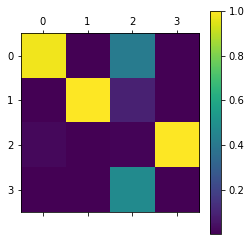

In [43]:
plt.matshow(gm.a)
plt.colorbar()

In [44]:
x = np.linspace(data[:, 0].min(), data[:, 0].max(), 300)
y = np.linspace(data[:, 1].min(), data[:, 1].max(), 300)
x, y = np.meshgrid(x, y)
plt.scatter(data[:, 0], data[:, 1], c=gm.predict(data))
plt.scatter(gm.mu[:, 0], gm.mu[:, 1], marker='+', c='r')
for i in range(4):
        plt.contour(x,
                    y,
                    gaussian_density(gm.mu[i, :], gm.sigma[i, :, :])(
                        np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)),
                        axis=1)).reshape(len(x), len(y)),
                    np.linspace(1e-3, 0.6, 50),
                    alpha=0.3)
        
plt.title("Training Data")

Text(0.5, 1.0, 'Training Data')

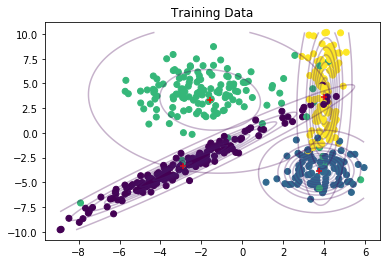

In [31]:
gm.pi

array([0., 0., 1., 0.])

In [32]:
gm.mu

array([[-2.8826136 , -3.385836  ],
       [ 3.76602329, -3.9004005 ],
       [-1.57167719,  3.33644796],
       [ 4.01818268,  3.63256257]])

In [33]:
gm.sigma

array([[[ 7.61619181,  7.33997069],
        [ 7.33997069,  7.40632238]],

       [[ 0.91480591,  0.05499016],
        [ 0.05499016,  1.81158083]],

       [[ 5.68159737, -0.51958306],
        [-0.51958306,  8.83369832]],

       [[ 0.19720148,  0.21430609],
        [ 0.21430609, 13.04446643]]])